In [1]:
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
from binance.futures import Futures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError

In [2]:
%%capture

config_logging(logging, logging.WARNING)

key = os.environ.get("API_KEY")
secret = os.environ.get("API_SECRET")

client = Client(key, secret,base_url="https://fapi.binance.com")

try:
    response = client.get_income_history(incomeType = "REALIZED_PNL", recvWindow=6000, limit=200)
except ClientError as error:
    logging.error(
        "Found error. status: {}, error code: {}, error message: {}".format(
            error.status_code, error.error_code, error.error_message
        )
    )

In [3]:
histPnl = pd.DataFrame.from_records(response)
histPnl["income"] = histPnl["income"].apply(pd.to_numeric)
histPnl["date"] = histPnl.time.apply(pd.to_datetime, unit="ms")
histPnl.drop(columns=["time", "info", "tranId", "tradeId", "incomeType", "asset"], inplace=True)
# histPnl.drop(columns=["time", "info", "incomeType"], inplace=True)
histPnl.index = list(range(len(histPnl)))

In [4]:
aggregation_functions = {'income': 'sum', 'symbol': 'first', 'date': 'first'}
histPnlAgg = histPnl.groupby(histPnl['date']).aggregate(aggregation_functions)
histPnlAgg.index = list(range(len(histPnlAgg)))


In [5]:
histPnlAgg

,income,symbol,date
0,0.2148,XTZUSDT,2022-04-30 20:07:42
1,0.2022,GTCUSDT,2022-04-30 20:07:46
2,0.3892,MATICUSDT,2022-04-30 20:07:48
3,0.8772,FTMUSDT,2022-04-30 20:07:53
4,0.2500,AXSUSDT,2022-04-30 20:07:58
...,...,...,...
121,-4.0770,GALUSDT,2022-05-06 00:38:37
122,1.1410,GALUSDT,2022-05-06 00:42:52
123,3.7093,GALUSDT,2022-05-06 00:45:31
124,0.8025,GALUSDT,2022-05-06 00:45:55


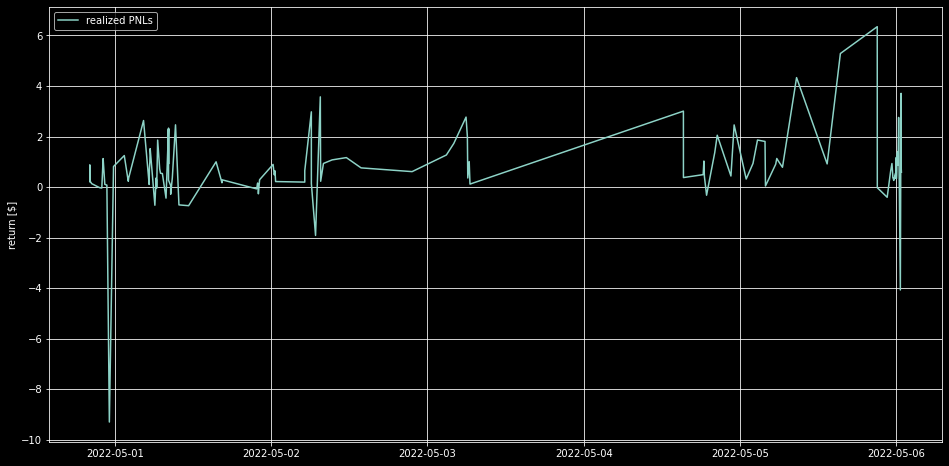

In [12]:
f, ax = plt.subplots(figsize=(16, 8))
ax.plot(histPnlAgg.date, histPnlAgg.income, label="realized PNLs")
ax.set_ylabel(r'return [\$]')
ax.grid(True)
ax.legend()

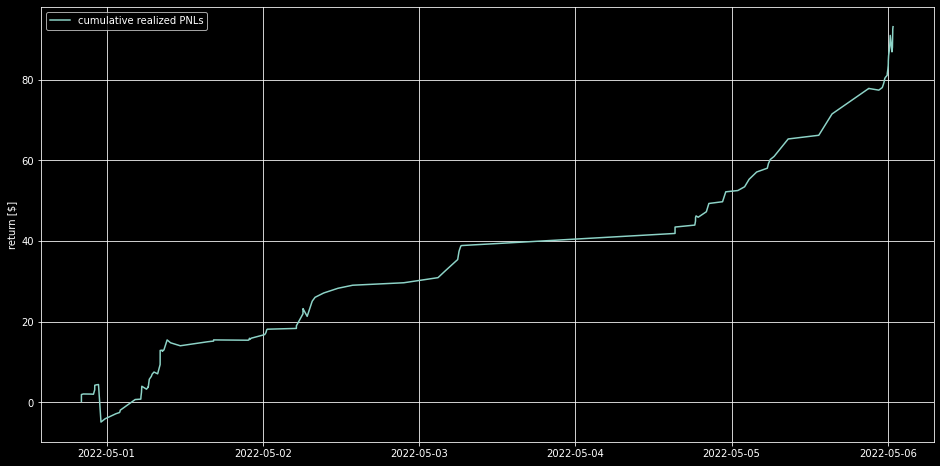

In [13]:
f, ax = plt.subplots(figsize=(16, 8))
ax.plot(histPnlAgg.date, histPnlAgg.income.cumsum(), label="cumulative realized PNLs")
ax.set_ylabel(r'return [\$]')
ax.grid()
ax.legend()

In [17]:
wins = histPnlAgg[histPnlAgg["income"] > 0]
losses = histPnlAgg[histPnlAgg["income"] < 0]
winrate = len(wins)/len(histPnlAgg)
lossrate = len(losses)/len(histPnlAgg)
winrate

0.873015873015873

In [18]:
avg_win = wins["income"].mean()
avg_win

1.0236655433636364

In [19]:
avg_loss = losses["income"].mean()
avg_loss

-1.2126099993750001

In [20]:
expected_return = avg_win*winrate + avg_loss*lossrate
expected_return #expected average return per trade?

0.7396940458730158